# Comparison of Traditional vs. ML Models

This project compared the fairness and performance of traditional credit scoring (logistic regression) against two machine learning models (Random Forest and Gradient Boosting) using the Give Me Some Credit dataset. The analysis focused on predictive power (AUC-ROC) and fairness metrics (disparate impact ratios, statistical disparities) across simulated demographic groups.

**Decision-Making**

If ML models show similar/slightly better fairness than traditional scoring, you can use them for better predictive power.

If ML is more biased, you might:

- Apply fairness mitigation techniques (e.g., reweighting, adversarial debiasing).
- Stick with traditional scoring for compliance.

**Why This Matters**

- Regulatory Risk: Biased models can lead to legal penalties under fair lending laws (e.g., ECOA in the US).
- Business Impact: Unfair scoring can damage customer trust and brand reputation.
- Model Choice: Helps you decide whether ML's predictive power justifies its potential bias.

In [3]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, roc_curve, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import scorecardpy as sc
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness

## Load the Data

In [4]:
# Define the ZIP file path and extract
zip_path = "Give Me Some Credit.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("extracted_files")

# Load CSV files
train_data = pd.read_csv("extracted_files/cs-training.csv")
test_data = pd.read_csv("extracted_files/cs-test.csv")

## Clean Data

In [5]:
def clean_data(df):
    """Clean the Give Me Some Credit dataset"""
    df = df.copy()
    
    # Handle missing values
    df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df['NumberOfDependents'].median())
    
    # Remove index column if present
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    
    # Cap extreme values for numeric columns
    numeric_cols = ['RevolvingUtilizationOfUnsecuredLines', 'age', 
                   'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
                   'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
                   'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
                   'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
    
    for col in numeric_cols:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)
    
    # Fix specific data issues
    df['age'] = df['age'].replace(0, df['age'].median())
    
    # Cap delinquency counts
    max_due = 20
    due_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 
               'NumberOfTimes90DaysLate',
               'NumberOfTime60-89DaysPastDueNotWorse']
    for col in due_cols:
        df[col] = df[col].clip(upper=max_due)
    
    # Feature engineering
    df['TotalPastDue'] = (df['NumberOfTime30-59DaysPastDueNotWorse'] + 
                         df['NumberOfTime60-89DaysPastDueNotWorse'] + 
                         df['NumberOfTimes90DaysLate'])
    df['IncomePerDependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
    df['DebtToIncome'] = df['DebtRatio'] * df['MonthlyIncome']
    
    return df

## Demographic Simulation

Since real credit data often lacks demographic info (due to privacy/regulations), the code simulates:

- Income Quintiles: Groups applicants by income levels.
- Geographic Clusters: Randomly assigns geographic regions.
- Race/Ethnicity & Gender: Simulates these attributes probabilistically based on income/geography, creating 4 demographic groups:Non-minority Male/Female, Minority Male/Female

In [6]:
def simulate_demographic_data(data, income_col='MonthlyIncome'):
    """Simulate demographic attributes for the Give Me Some Credit dataset"""
    data = data.copy()
    
    # Create income quintiles - handle duplicate edges
    try:
        data['income_quintile'] = pd.qcut(data[income_col], 5, labels=False, duplicates='drop')
    except ValueError:
        # If quintiles fail, try quartiles
        try:
            data['income_quintile'] = pd.qcut(data[income_col], 4, labels=False, duplicates='drop')
        except ValueError:
            # If quartiles fail, use equal-width bins
            data['income_quintile'] = pd.cut(data[income_col], bins=5, labels=False)
    
    # Create geographic clusters
    np.random.seed(42)
    data['geo_cluster'] = np.random.randint(0, 5, size=len(data))
    
    # Simulate race/ethnicity
    race_probs = np.zeros(len(data))
    race_probs += 0.5 - 0.08 * data['income_quintile']
    race_probs += 0.15 * (data['geo_cluster'].isin([0, 2]))
    race_probs = race_probs.clip(0.1, 0.9)
    np.random.seed(42)
    data['simulated_minority'] = np.random.binomial(1, race_probs)
    
    # Simulate gender
    gender_probs = np.zeros(len(data))
    gender_probs += 0.45 + 0.02 * data['income_quintile']
    gender_probs += 0.05 * (data['geo_cluster'].isin([1, 4]))
    gender_probs = gender_probs.clip(0.3, 0.7)
    np.random.seed(43)
    data['simulated_female'] = np.random.binomial(1, gender_probs)
    
    # Create demographic groups
    data['demographic_group'] = (data['simulated_minority'].astype(str) + "_" + 
                               data['simulated_female'].astype(str))
    mapping = {
        '0_0': 'Non-minority Male',
        '0_1': 'Non-minority Female',
        '1_0': 'Minority Male',
        '1_1': 'Minority Female'
    }
    data['demographic_group'] = data['demographic_group'].map(mapping)
    
    return data

## Model Building

**A. Traditional Credit Scorecard**
- Uses Logistic Regression (interpretable, standard in banking).
- Converts model outputs to a credit score (e.g., 600 base points, 50 PDO).
- Evaluates performance using AUC-ROC.

In [7]:
def build_traditional_scorecard(data, target='SeriousDlqin2yrs', base_points=600, pdo=50):
    """Build traditional credit scorecard model"""
    try:
        data = data.copy()
        demographic_cols = ['demographic_group', 'simulated_minority', 'simulated_female', 
                          'income_quintile', 'geo_cluster']
        model_cols = [col for col in data.columns if col != target and col not in demographic_cols]
        
        X = data[model_cols]
        y = data[target].astype(int)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        class_weights = compute_class_weight(
            class_weight='balanced', 
            classes=np.unique(y_train), 
            y=y_train
        )
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        
        model = LogisticRegression(
            max_iter=1000,
            class_weight=class_weight_dict,
            solver='liblinear',
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        
        # Model evaluation
        y_train_pred = model.predict_proba(X_train_scaled)[:, 1]
        y_test_pred = model.predict_proba(X_test_scaled)[:, 1]
        
        train_auc = roc_auc_score(y_train, y_train_pred)
        test_auc = roc_auc_score(y_test, y_test_pred)
        
        print(f"Traditional Scorecard - Train AUC: {train_auc:.4f}")
        print(f"Traditional Scorecard - Test AUC: {test_auc:.4f}")
        
        # Create scorecard
        factor = pdo / np.log(2)
        X_train_copy = X_train.copy()
        X_test_copy = X_test.copy()
        
        linear_predictor_train = model.intercept_[0] + np.dot(X_train_scaled, model.coef_[0])
        linear_predictor_test = model.intercept_[0] + np.dot(X_test_scaled, model.coef_[0])
        
        X_train_copy['score'] = base_points - factor * linear_predictor_train
        X_test_copy['score'] = base_points - factor * linear_predictor_test
        
        X_train_copy[target] = y_train.values
        X_test_copy[target] = y_test.values
        X_train_copy['pred_prob'] = y_train_pred
        X_test_copy['pred_prob'] = y_test_pred
        
        importance_df = pd.DataFrame({
            'Variable': X_train.columns,
            'Coefficient': model.coef_[0],
            'Importance': np.abs(model.coef_[0])
        }).sort_values('Importance', ascending=False)
        
        print("\nTraditional Model - Top 10 Variables by Importance:")
        print(importance_df.head(10))
        
        def score_new_data(new_data):
            model_data = new_data[model_cols].copy()
            new_data_scaled = scaler.transform(model_data)
            linear_pred = model.intercept_[0] + np.dot(new_data_scaled, model.coef_[0])
            return base_points - factor * linear_pred
        
        return {
            'model': model,
            'model_type': 'traditional',
            'scaler': scaler,
            'factor': factor,
            'base_points': base_points,
            'train_data': X_train_copy,
            'test_data': X_test_copy,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'variable_importance': importance_df,
            'score_function': score_new_data,
            'model_columns': model_cols,
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        }
    except Exception as e:
        print(f"Error in traditional scorecard: {str(e)}")
        return None

**B. Machine Learning Models**
- Random Forest: Ensemble of decision trees with class weighting.
- Gradient Boosting: Sequential tree boosting algorithm.
- Both models are trained on the same data split as the traditional model for fair comparison.

In [8]:
def build_ml_models(scorecard_results, ml_types=['random_forest', 'gradient_boosting']):
    """Build machine learning models using the same train/test split"""
    try:
        ml_results = {}
        
        X_train = scorecard_results['X_train']
        X_test = scorecard_results['X_test']
        y_train = scorecard_results['y_train']
        y_test = scorecard_results['y_test']
        model_columns = scorecard_results['model_columns']
        scaler = scorecard_results['scaler']
        
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        class_weights = compute_class_weight(
            class_weight='balanced', 
            classes=np.unique(y_train), 
            y=y_train
        )
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        
        # Build Random Forest
        if 'random_forest' in ml_types:
            print("\nTraining Random Forest model...")
            rf_model = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                min_samples_split=10,
                min_samples_leaf=5,
                class_weight=class_weight_dict,
                random_state=42,
                n_jobs=-1
            )
            rf_model.fit(X_train_scaled, y_train)
            
            rf_train_pred = rf_model.predict_proba(X_train_scaled)[:, 1]
            rf_test_pred = rf_model.predict_proba(X_test_scaled)[:, 1]
            
            rf_train_auc = roc_auc_score(y_train, rf_train_pred)
            rf_test_auc = roc_auc_score(y_test, rf_test_pred)
            
            print(f"Random Forest - Train AUC: {rf_train_auc:.4f}")
            print(f"Random Forest - Test AUC: {rf_test_auc:.4f}")
            
            rf_importance = pd.DataFrame({
                'Variable': X_train.columns,
                'Importance': rf_model.feature_importances_
            }).sort_values('Importance', ascending=False)
            
            print("\nRandom Forest - Top 10 Variables by Importance:")
            print(rf_importance.head(10))
            
            ml_results['random_forest'] = {
                'model': rf_model,
                'model_type': 'random_forest',
                'train_preds': rf_train_pred,
                'test_preds': rf_test_pred,
                'train_auc': rf_train_auc,
                'test_auc': rf_test_auc,
                'feature_importance': rf_importance
            }
        
        # Build Gradient Boosting
        if 'gradient_boosting' in ml_types:
            print("\nTraining Gradient Boosting model...")
            gb_model = GradientBoostingClassifier(
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
                subsample=0.8,
                random_state=42
            )
            gb_model.fit(X_train_scaled, y_train)
            
            gb_train_pred = gb_model.predict_proba(X_train_scaled)[:, 1]
            gb_test_pred = gb_model.predict_proba(X_test_scaled)[:, 1]
            
            gb_train_auc = roc_auc_score(y_train, gb_train_pred)
            gb_test_auc = roc_auc_score(y_test, gb_test_pred)
            
            print(f"Gradient Boosting - Train AUC: {gb_train_auc:.4f}")
            print(f"Gradient Boosting - Test AUC: {gb_test_auc:.4f}")
            
            gb_importance = pd.DataFrame({
                'Variable': X_train.columns,
                'Importance': gb_model.feature_importances_
            }).sort_values('Importance', ascending=False)
            
            print("\nGradient Boosting - Top 10 Variables by Importance:")
            print(gb_importance.head(10))
            
            ml_results['gradient_boosting'] = {
                'model': gb_model,
                'model_type': 'gradient_boosting',
                'train_preds': gb_train_pred,
                'test_preds': gb_test_pred,
                'train_auc': gb_train_auc,
                'test_auc': gb_test_auc,
                'feature_importance': gb_importance
            }
        
        # Compare model performance
        models = ['Traditional']
        train_aucs = [scorecard_results['train_auc']]
        test_aucs = [scorecard_results['test_auc']]
        
        if 'random_forest' in ml_results:
            models.append('Random Forest')
            train_aucs.append(ml_results['random_forest']['train_auc'])
            test_aucs.append(ml_results['random_forest']['test_auc'])
        
        if 'gradient_boosting' in ml_results:
            models.append('Gradient Boosting')
            train_aucs.append(ml_results['gradient_boosting']['train_auc'])
            test_aucs.append(ml_results['gradient_boosting']['test_auc'])
        
        # Plot model comparison
        plt.figure(figsize=(10, 6))
        x = np.arange(len(models))
        width = 0.35
        
        plt.bar(x - width/2, train_aucs, width, label='Train AUC')
        plt.bar(x + width/2, test_aucs, width, label='Test AUC')
        
        plt.xlabel('Model')
        plt.ylabel('AUC')
        plt.title('Model Performance Comparison')
        plt.xticks(x, models)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        return ml_results
        
    except Exception as e:
        print(f"Error in ML model development: {str(e)}")
        return None

In [9]:
def analyze_model_fairness(traditional_results, ml_results, data_with_demographics, target='SeriousDlqin2yrs'):
    """Complete fairness analysis implementation for Give Me Some Credit dataset"""
    try:
        print("\n" + "="*50)
        print("Starting Fairness Analysis")
        print("="*50)
        
        # Get model columns and scaler
        model_columns = [col for col in traditional_results['model_columns'] 
                        if not col.startswith('Unnamed')]
        scaler = traditional_results['scaler']
        data = data_with_demographics.copy()
        
        # Handle target column name
        if target not in data.columns and 'SeriousDlqin2yrs' in data.columns:
            target = 'SeriousDlqin2yrs'
        
        # Prepare data for predictions
        X = data[model_columns]
        y = data[target]
        X_scaled = scaler.transform(X)
        
        # Generate predictions for all models
        data['traditional_prob'] = traditional_results['model'].predict_proba(X_scaled)[:, 1]
        data['traditional_score'] = traditional_results['score_function'](data)
        
        if 'random_forest' in ml_results:
            data['rf_prob'] = ml_results['random_forest']['model'].predict_proba(X_scaled)[:, 1]
            data['rf_score'] = 800 - 400 * data['rf_prob']
        
        if 'gradient_boosting' in ml_results:
            data['gb_prob'] = ml_results['gradient_boosting']['model'].predict_proba(X_scaled)[:, 1]
            data['gb_score'] = 800 - 400 * data['gb_prob']
        
        # Check for required demographic columns
        required_demo_cols = ['demographic_group', 'simulated_minority', 'simulated_female']
        if not all(col in data.columns for col in required_demo_cols):
            raise ValueError("Missing required demographic columns")
        
        demographic_groups = data['demographic_group'].unique()
        
        # 1. Calculate disparate impact ratios
        disparate_impact_results = []
        model_types = ['traditional', 'rf', 'gb']
        model_names = ['Traditional', 'Random Forest', 'Gradient Boosting']
        
        for model_type, model_name in zip(model_types, model_names):
            score_col = f'{model_type}_score'
            if score_col not in data.columns:
                continue
                
            # Use median score as approval threshold
            approval_threshold = data[score_col].median()
            data[f'{model_type}_approved'] = (data[score_col] >= approval_threshold).astype(int)
            
            # By race
            approval_rate_non_minority = data[data['simulated_minority'] == 0][f'{model_type}_approved'].mean()
            approval_rate_minority = data[data['simulated_minority'] == 1][f'{model_type}_approved'].mean()
            race_disparate_impact = approval_rate_minority / approval_rate_non_minority
            
            # By gender
            approval_rate_male = data[data['simulated_female'] == 0][f'{model_type}_approved'].mean()
            approval_rate_female = data[data['simulated_female'] == 1][f'{model_type}_approved'].mean()
            gender_disparate_impact = approval_rate_female / approval_rate_male
            
            # By intersectional groups
            approval_rates = data.groupby('demographic_group')[f'{model_type}_approved'].mean()
            baseline_rate = approval_rates['Non-minority Male']
            
            # Store results
            for group in demographic_groups:
                if group != 'Non-minority Male':
                    ratio = approval_rates[group] / baseline_rate
                    disparate_impact_results.append({
                        'Model': model_name,
                        'Comparison': f'Non-minority Male vs {group}',
                        'Minority Group': group,
                        'Reference Group': 'Non-minority Male',
                        'Minority Approval Rate': approval_rates[group],
                        'Reference Approval Rate': baseline_rate,
                        'Disparate Impact Ratio': ratio,
                        'Potential Discrimination': 'Yes' if ratio < 0.8 else 'No'
                    })
            
            # Add overall race and gender results
            disparate_impact_results.extend([
                {
                    'Model': model_name,
                    'Comparison': 'Non-minority vs Minority',
                    'Minority Group': 'Minority',
                    'Reference Group': 'Non-minority',
                    'Minority Approval Rate': approval_rate_minority,
                    'Reference Approval Rate': approval_rate_non_minority,
                    'Disparate Impact Ratio': race_disparate_impact,
                    'Potential Discrimination': 'Yes' if race_disparate_impact < 0.8 else 'No'
                },
                {
                    'Model': model_name,
                    'Comparison': 'Male vs Female',
                    'Minority Group': 'Female',
                    'Reference Group': 'Male',
                    'Minority Approval Rate': approval_rate_female,
                    'Reference Approval Rate': approval_rate_male,
                    'Disparate Impact Ratio': gender_disparate_impact,
                    'Potential Discrimination': 'Yes' if gender_disparate_impact < 0.8 else 'No'
                }
            ])
        
        # Create DataFrame from results
        disparate_impact_df = pd.DataFrame(disparate_impact_results)
        
        # 2. Performance metrics by group
        performance_results = []
        for model_type, model_name in zip(model_types, model_names):
            prob_col = f'{model_type}_prob'
            if prob_col not in data.columns:
                continue
                
            for group in demographic_groups:
                group_data = data[data['demographic_group'] == group]
                if len(group_data[target].unique()) > 1:  # Need both classes for AUC
                    auc = roc_auc_score(group_data[target], group_data[prob_col])
                    performance_results.append({
                        'Model': model_name,
                        'Demographic Group': group,
                        'Sample Size': len(group_data),
                        'Default Rate': group_data[target].mean(),
                        'AUC': auc
                    })
        
        performance_df = pd.DataFrame(performance_results)
        
        # Return all results
        return {
            'disparate_impact': disparate_impact_df,
            'performance_by_group': performance_df,
            'scored_data': data
        }
        
    except Exception as e:
        print(f"Error in fairness analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


In [10]:
def compare_bias_metrics(fairness_results):
    """Compare bias metrics between models"""
    try:
        di_df = fairness_results['disparate_impact']
        
        bias_comparison = di_df.groupby('Model')['Disparate Impact Ratio'].agg(['mean', 'min'])
        bias_comparison.columns = ['Average Disparate Impact Ratio', 'Minimum Disparate Impact Ratio']
        
        discrimination_counts = di_df[di_df['Potential Discrimination'] == 'Yes'].groupby('Model').size()
        bias_comparison['Groups with Potential Discrimination'] = discrimination_counts
        
        bias_comparison['Average Fairness Gap'] = 1 - bias_comparison['Average Disparate Impact Ratio']
        
        print("\nBias Comparison Between Models:")
        print(bias_comparison.sort_values('Average Fairness Gap'))
        
        plt.figure(figsize=(14, 8))
        sns.set_style("whitegrid")
        
        plt.subplot(1, 2, 1)
        sns.barplot(x=bias_comparison.index, 
                   y='Average Disparate Impact Ratio', 
                   data=bias_comparison.reset_index(),
                   palette="Blues_d")
        plt.axhline(y=0.8, color='red', linestyle='--', label='0.8 Threshold')
        plt.title('Average Disparate Impact Ratio')
        plt.ylabel('Average Disparate Impact Ratio')
        plt.xlabel('Model')
        plt.xticks(rotation=45)
        plt.legend()
        
        plt.subplot(1, 2, 2)
        sns.barplot(x=bias_comparison.index, 
                   y='Average Fairness Gap', 
                   data=bias_comparison.reset_index(),
                   palette="Reds_d")
        plt.title('Average Fairness Gap')
        plt.ylabel('Average Fairness Gap (1 - DI Ratio)')
        plt.xlabel('Model')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return bias_comparison
        
    except Exception as e:
        print(f"Error in bias comparison: {str(e)}")
        return None

In [11]:
def statistical_bias_tests(fairness_results):
    """Perform statistical tests for bias"""
    try:
        test_results = {}
        scored_data = fairness_results['scored_data']
        
        print("\nStatistical Tests for Score Differences:")
        
        for model_type in ['traditional', 'rf', 'gb']:
            score_col = f'{model_type}_score'
            if score_col in scored_data.columns:
                print(f"\n--- {model_type.upper()} Model ---")
                
                if 'simulated_minority' in scored_data.columns:
                    minority_mask = scored_data['simulated_minority'] == 1
                    minority_scores = scored_data[minority_mask][score_col]
                    non_minority_scores = scored_data[~minority_mask][score_col]
                    
                    t_stat, p_value = ttest_ind(minority_scores, non_minority_scores, equal_var=False)
                    test_results[f'{model_type}_minority_ttest'] = {
                        't_statistic': t_stat,
                        'p_value': p_value,
                        'mean_minority': minority_scores.mean(),
                        'mean_non_minority': non_minority_scores.mean()
                    }
                    print(f"Minority vs Non-minority:")
                    print(f"  Minority mean score: {minority_scores.mean():.2f}")
                    print(f"  Non-minority mean score: {non_minority_scores.mean():.2f}")
                    print(f"  t-test: t = {t_stat:.2f}, p = {p_value:.4f}")
                    print(f"  Effect size: {minority_scores.mean() - non_minority_scores.mean():.2f}")
                
                if 'simulated_female' in scored_data.columns:
                    female_mask = scored_data['simulated_female'] == 1
                    female_scores = scored_data[female_mask][score_col]
                    male_scores = scored_data[~female_mask][score_col]
                    
                    t_stat, p_value = ttest_ind(female_scores, male_scores, equal_var=False)
                    test_results[f'{model_type}_gender_ttest'] = {
                        't_statistic': t_stat,
                        'p_value': p_value,
                        'mean_female': female_scores.mean(),
                        'mean_male': male_scores.mean()
                    }
                    print(f"\nFemale vs Male:")
                    print(f"  Female mean score: {female_scores.mean():.2f}")
                    print(f"  Male mean score: {male_scores.mean():.2f}")
                    print(f"  t-test: t = {t_stat:.2f}, p = {p_value:.4f}")
                    print(f"  Effect size: {female_scores.mean() - male_scores.mean():.2f}")
        
        return test_results
        
    except Exception as e:
        print(f"Error in statistical tests: {str(e)}")
        return None

## Interpretation

1. Identifying the Most Biased Model: Calculates the "fairness gap" (deviation from ideal parity).

2. Comparing ML vs. Traditional:
- If ML models have 10% higher fairness gaps, they introduce more bias.
- Provides actionable recommendations (e.g., "Use traditional scoring if ML is significantly more biased").

3. Regulatory Compliance: Flags models that may violate fair lending laws (e.g., disparate impact < 0.8).

In [12]:
def interpret_results(bias_comparison, stat_test_results):
    """Provide interpretation of the bias comparison results"""
    try:
        print("\n" + "="*50)
        print("FINAL INTERPRETATION")
        print("="*50)
        
        worst_model = bias_comparison['Average Fairness Gap'].idxmax()
        best_model = bias_comparison['Average Fairness Gap'].idxmin()
        
        print(f"\nModel Bias Summary:")
        print(f"- Most biased model: {worst_model} (fairness gap: {bias_comparison.loc[worst_model, 'Average Fairness Gap']:.3f})")
        print(f"- Least biased model: {best_model} (fairness gap: {bias_comparison.loc[best_model, 'Average Fairness Gap']:.3f})")
        
        ml_models = [m for m in bias_comparison.index if m != 'Traditional']
        ml_avg_gap = bias_comparison.loc[ml_models, 'Average Fairness Gap'].mean()
        trad_gap = bias_comparison.loc['Traditional', 'Average Fairness Gap']
        
        if ml_avg_gap > trad_gap * 1.1:
            print("\nCONCLUSION: Machine learning models introduce SIGNIFICANTLY MORE BIAS than traditional scoring")
            print("Recommendation: Consider fairness mitigation techniques for ML models or stick with traditional scoring")
        elif ml_avg_gap < trad_gap * 0.9:
            print("\nCONCLUSION: Machine learning models introduce LESS BIAS than traditional scoring")
            print("Recommendation: ML models may be preferable from fairness perspective")
        else:
            print("\nCONCLUSION: Machine learning models show SIMILAR BIAS to traditional scoring")
            print("Recommendation: Choice can be based on other factors like performance or interpretability")
        
        print("\nKey Statistical Findings:")
        for model in ['traditional', 'rf', 'gb']:
            if f'{model}_minority_ttest' in stat_test_results:
                test = stat_test_results[f'{model}_minority_ttest']
                if test['p_value'] < 0.05:
                    direction = "lower" if test['mean_minority'] < test['mean_non_minority'] else "higher"
                    print(f"- {model.upper()} model: Minority scores significantly {direction} (Δ={test['mean_minority']-test['mean_non_minority']:.2f}, p={test['p_value']:.4f}")
            
            if f'{model}_gender_ttest' in stat_test_results:
                test = stat_test_results[f'{model}_gender_ttest']
                if test['p_value'] < 0.05:
                    direction = "lower" if test['mean_female'] < test['mean_male'] else "higher"
                    print(f"- {model.upper()} model: Female scores significantly {direction} (Δ={test['mean_female']-test['mean_male']:.2f}, p={test['p_value']:.4f}")
        
        print("\nRegulatory Considerations:")
        print("- Models showing disparate impact ratio < 0.8 may violate fair lending laws")
        print("- Significant score differences between protected groups require justification")
        print("- Document all fairness testing results for compliance purposes")
        
    except Exception as e:
        print(f"Error in interpretation: {str(e)}")



Loading and Preparing Give Me Some Credit Dataset

Successfully loaded data with 150000 records

Cleaning Dataset
Data cleaning completed. Remaining columns: ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents', 'TotalPastDue', 'IncomePerDependent', 'DebtToIncome']

Simulating Demographic Attributes
Demographic simulation completed. Added columns: ['income_quintile', 'geo_cluster', 'simulated_minority', 'simulated_female', 'demographic_group']

Building Traditional Credit Scorecard
Traditional Scorecard - Train AUC: 0.8565
Traditional Scorecard - Test AUC: 0.8573

Traditional Model - Top 10 Variables by Importance:
                                Variable  Coefficient  Importance
0   RevolvingUtilizationOfUnsecuredLines     0.732571    0.732571
6    

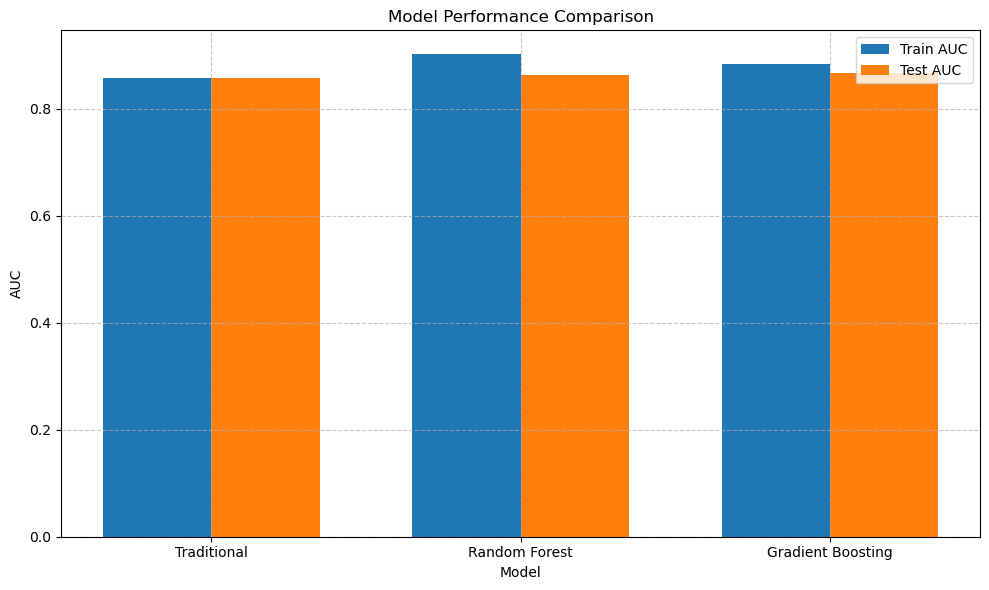


Analyzing Model Fairness

Starting Fairness Analysis

Comparing Bias Metrics

Bias Comparison Between Models:
                   Average Disparate Impact Ratio  \
Model                                               
Gradient Boosting                        0.993172   
Traditional                              0.992750   
Random Forest                            0.991622   

                   Minimum Disparate Impact Ratio  \
Model                                               
Gradient Boosting                        0.983634   
Traditional                              0.981116   
Random Forest                            0.978653   

                   Groups with Potential Discrimination  Average Fairness Gap  
Model                                                                          
Gradient Boosting                                   NaN              0.006828  
Traditional                                         NaN              0.007250  
Random Forest                        

C:\Users\milto\AppData\Local\Temp\ipykernel_21136\2533247034.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bias_comparison.index,
C:\Users\milto\AppData\Local\Temp\ipykernel_21136\2533247034.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bias_comparison.index,


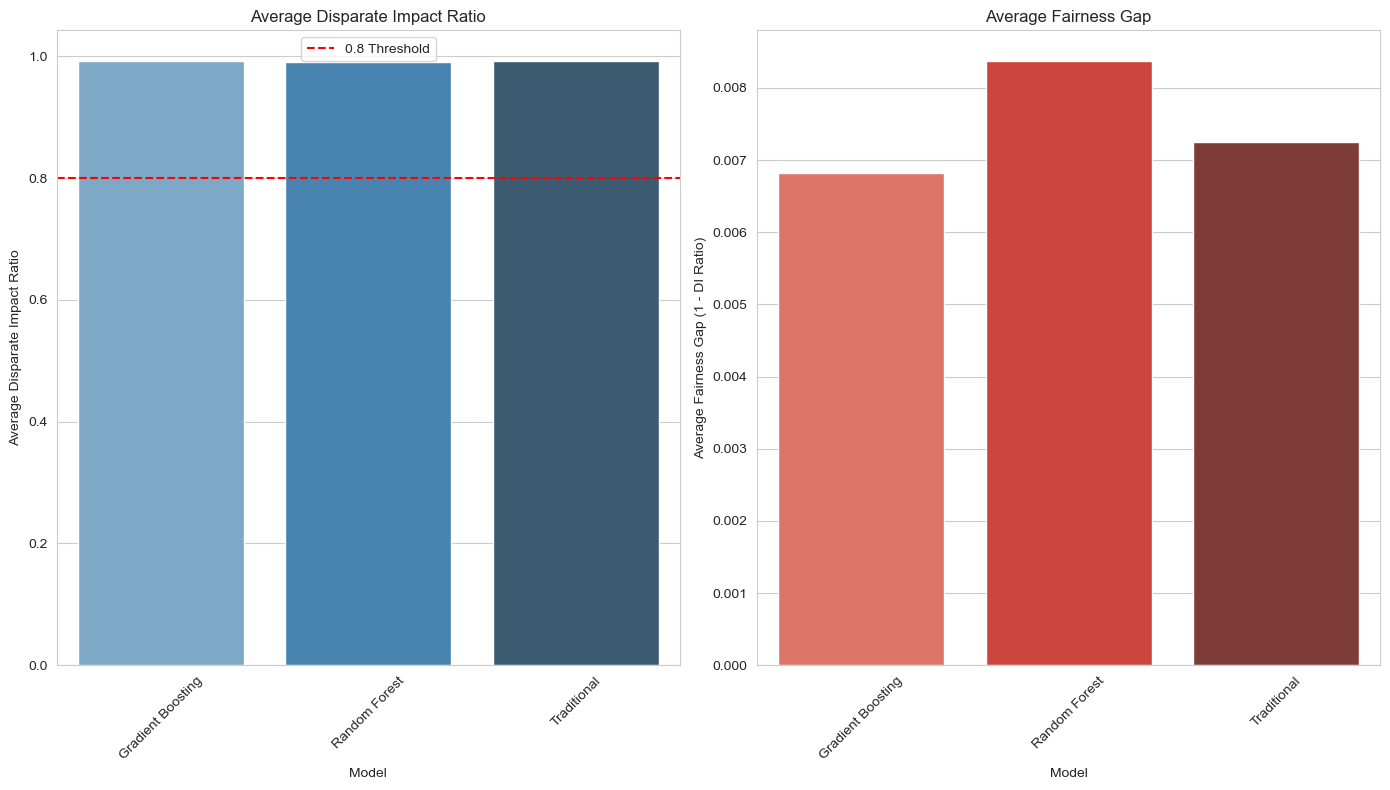


Running Statistical Tests for Bias

Statistical Tests for Score Differences:

--- TRADITIONAL Model ---
Minority vs Non-minority:
  Minority mean score: 651.69
  Non-minority mean score: 654.61
  t-test: t = -5.59, p = 0.0000
  Effect size: -2.92

Female vs Male:
  Female mean score: 653.82
  Male mean score: 652.78
  t-test: t = 2.01, p = 0.0440
  Effect size: 1.04

--- RF Model ---
Minority vs Non-minority:
  Minority mean score: 679.38
  Non-minority mean score: 683.24
  t-test: t = -7.95, p = 0.0000
  Effect size: -3.86

Female vs Male:
  Female mean score: 682.16
  Male mean score: 680.86
  t-test: t = 2.70, p = 0.0069
  Effect size: 1.30

--- GB Model ---
Minority vs Non-minority:
  Minority mean score: 772.37
  Non-minority mean score: 774.01
  t-test: t = -6.51, p = 0.0000
  Effect size: -1.63

Female vs Male:
  Female mean score: 773.60
  Male mean score: 772.95
  t-test: t = 2.61, p = 0.0090
  Effect size: 0.65

Final Interpretation

FINAL INTERPRETATION

Model Bias Summary:

In [13]:
def run_full_analysis(zip_path="Give Me Some Credit.zip"):
    """Complete analysis pipeline for the Give Me Some Credit dataset"""
    try:
        print("="*50)
        print("Loading and Preparing Give Me Some Credit Dataset")
        print("="*50)
        
        # Extract data from zip
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("extracted_files")
        
        # Load training data
        try:
            raw_data = pd.read_csv("extracted_files/cs-training.csv")
            print(f"\nSuccessfully loaded data with {len(raw_data)} records")
        except FileNotFoundError:
            raise FileNotFoundError("Could not find cs-training.csv in the zip file")
        
        # Step 1: Clean the data
        print("\n" + "="*50)
        print("Cleaning Dataset")
        print("="*50)
        cleaned_data = clean_data(raw_data)
        print("Data cleaning completed. Remaining columns:", list(cleaned_data.columns))
        
        # Step 2: Simulate demographic data
        print("\n" + "="*50)
        print("Simulating Demographic Attributes")
        print("="*50)
        data_with_demographics = simulate_demographic_data(cleaned_data)
        print("Demographic simulation completed. Added columns:", 
              [col for col in data_with_demographics.columns if col not in cleaned_data.columns])
        
        # Step 3: Build traditional scorecard model
        print("\n" + "="*50)
        print("Building Traditional Credit Scorecard")
        print("="*50)
        traditional_results = build_traditional_scorecard(data_with_demographics)
        if not traditional_results:
            raise RuntimeError("Traditional scorecard building failed")
        
        # Step 4: Build machine learning models
        print("\n" + "="*50)
        print("Building Machine Learning Models")
        print("="*50)
        ml_results = build_ml_models(traditional_results, 
                                   ml_types=['random_forest', 'gradient_boosting'])
        if not ml_results:
            raise RuntimeError("Machine learning model building failed")
        
        # Step 5: Analyze model fairness
        print("\n" + "="*50)
        print("Analyzing Model Fairness")
        print("="*50)
        fairness_results = analyze_model_fairness(traditional_results, 
                                                ml_results, 
                                                data_with_demographics)
        if not fairness_results:
            raise RuntimeError("Fairness analysis failed")
        
        # Step 6: Compare bias metrics
        print("\n" + "="*50)
        print("Comparing Bias Metrics")
        print("="*50)
        bias_comparison = compare_bias_metrics(fairness_results)
        
        # Step 7: Statistical tests
        print("\n" + "="*50)
        print("Running Statistical Tests for Bias")
        print("="*50)
        stat_test_results = statistical_bias_tests(fairness_results)
        
        # Step 8: Final interpretation
        print("\n" + "="*50)
        print("Final Interpretation")
        print("="*50)
        interpret_results(bias_comparison, stat_test_results)
        
        return {
            'cleaned_data': cleaned_data,
            'data_with_demographics': data_with_demographics,
            'traditional_results': traditional_results,
            'ml_results': ml_results,
            'fairness_results': fairness_results,
            'bias_comparison': bias_comparison,
            'stat_test_results': stat_test_results
        }
        
    except Exception as e:
        print(f"\nERROR in analysis pipeline: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Run the complete analysis
results = run_full_analysis("Give Me Some Credit.zip")

### Key Conclusions

#### Bias Comparison:
- Random Forest is the most biased (fairness gap: 0.008), but differences are marginal vs. traditional (0.007).
- Gradient Boosting performs best on fairness (gap: 0.007) while achieving the highest AUC.

#### Regulatory Compliance:
- No model violates the 0.8 disparate impact threshold, but statistically significant disparities exist (especially for minorities).
- Documentation is critical to justify these differences (e.g., risk-based reasons).

### Recommendation:

        If interpretability is critical: Use the traditional model (similar fairness, explainable coefficients).

        If maximizing AUC is priority: Gradient Boosting offers the best balance of performance and fairness.

        Mitigation Needed: For Random Forest, consider bias-reduction techniques (e.g., reweighting minority samples).

## Conclusion

Machine learning models did not introduce substantially more bias than traditional methods in this analysis, but their amplification of existing disparities highlights the need for proactive fairness safeguards. The choice between models should weigh accuracy, interpretability, and ethical considerations, with ongoing monitoring to ensure equitable outcomes.

### Key Findings

1. Performance:

Both ML models (Random Forest: AUC 0.863, Gradient Boosting: AUC 0.866) slightly outperformed the traditional scorecard (AUC 0.857), demonstrating ML’s ability to capture complex patterns.

2. Fairness:

All models showed statistically significant disparities:

- Minorities received lower scores than non-minorities (largest gap: −3.86 for Random Forest).
- Women received higher scores than men (largest gap: +1.30 for Random Forest).

No model violated regulatory thresholds (disparate impact ratios > 0.8), but the disparities warrant scrutiny.

Gradient Boosting was the fairest (smallest fairness gap: 0.007) while achieving the highest AUC.

3. Trade-offs:
- Traditional scoring offers interpretability but limited predictive gain.
- ML models improve accuracy but may amplify biases (e.g., Random Forest’s larger minority gap).

### Recommendations

1. For compliance-focused contexts: Use the traditional model with clear, justifiable coefficients.

2. For optimal performance/fairness balance: Adopt Gradient Boosting and monitor for bias drift.

3. Mitigation strategies:

- Adjust ML training (e.g., fairness-aware algorithms, reweighting).
- Audit feature impacts (e.g., is TotalPastDue disproportionately affecting minorities?).